In [1]:
# To use the dashboard mode, download jupyter dashboard. 
#url: http://jupyter-dashboards-layout.readthedocs.io/en/latest/getting-started.html 

In [2]:
# please set your MySQL password to access the databases after they have been created
password = "******"

In [3]:
#-----------------------------------------------------------------------------------------------------------------
#                                           Import Libraries
#-----------------------------------------------------------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

#Set Global plotting parameters
mpl.rcParams["font.size"] = '18'

from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import pandas as pd
from mpl_toolkits.basemap import Basemap
import pymysql as pymysql
import pymysql.cursors
# Import packages for plotly
import plotly as plotly
import plotly.dashboard_objs as dashboard
import IPython.display
from IPython.display import Image
import plotly.graph_objs as go
from plotly.graph_objs import *
import plotly.plotly as py
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot


In [4]:
#-----------------------------------------------------------------------------------------------------------------
#                                           Functions
#-----------------------------------------------------------------------------------------------------------------
# parse string of coordinates into list of float64 numpy arrays
def parseCoord(coord):
    parsedCoord = []
    for i in range(len(coord)):
        tmp = coord[i]
        tmp = tmp.replace(tmp[0],"")
        tmp = tmp.replace(tmp[len(tmp)-1],"")
        # remove \n's
        tmp = tmp.replace('\n',"")
        # remove extra spaces to split correctly
        tmp = ' '.join(tmp.split())
        # split
        tmp = tmp.split(" ")
        # convert each item in list to float
        tmp = list(map(float, tmp))
        parsedCoord.append(np.array(tmp,dtype = np.float64))
    return parsedCoord
#--------------------------------End-FUNC--------------------------------------
# create a basemap plot 
def basemapPlotColormap(data,mapBounds,borderBounds,title,cbLabel,cmap):
    # clear the variable patches
    xCoord = borderBounds[0]
    yCoord = borderBounds[1]
    patches = []
    fig, ax = plt.subplots(figsize=(20,10)) # create a plot
    plt.title(title)
    # create the base map
    m = Basemap(projection = "lcc", lon_0 = mapBounds[0],lat_0 = mapBounds[1],\
        resolution = 'l',llcrnrlat = mapBounds[2],llcrnrlon = mapBounds[3],\
        urcrnrlat = mapBounds[4],urcrnrlon = mapBounds[5])
    # Create patches
    for i in range(0,77):
        # Put Coordinates on the map axis
        X, Y  = m(xCoord[i], yCoord[i])
        xy = np.vstack([X,Y]).T
        # create polygon in the axis
        polygon = Polygon( xy, True)
        patches.append(polygon)
    # Add Border to boundaries
    for i in range(len(xCoord)):
        m.plot(xCoord[i],yCoord[i], latlon = True, color = 'k',linewidth = 1,zorder = 3)
    # Color Patches
    p = PatchCollection(patches, cmap=cmap, zorder=2)
    colors = data
    p.set_array(np.array(colors))
    #grab current axis and place polygons
    plt.gca().add_collection(p)
    plt.gca().axis("off")
    # add a colorbar
    cax = fig.add_axes([0.65, 0.125, 0.01, 0.75]) # Where to place ColorBar
    norm = mpl.colors.Normalize(vmin = data.min(),vmax = data.max()) # normalize data for colorbar
    cb = mpl.colorbar.ColorbarBase(cax, cmap = cmap,norm = norm,orientation = 'vertical') # colorbar settings
    cb.set_label(cbLabel) # place the colorbar
    #plt.savefig(str(title)+'.png', bbox_inches='tight')
    plt.show()

In [5]:
#-----------------------------------------------------------------------------------------------------------------
#                                           SQL Queries
#-----------------------------------------------------------------------------------------------------------------
resTotKwhQuery = '''SELECT COMMUNITY_AREA_NAME,SUM(TOTAL_KWH) AS TOT_KWH
    FROM CensusBlocks
    WHERE BUILDING_TYPE = 'Residential'
    GROUP BY COMMUNITY_AREA_NAME
    ORDER BY COMMUNITY_AREA_NAME;'''
comTotKwhQuery = '''SELECT COMMUNITY_AREA_NAME,SUM(TOTAL_KWH) AS TOT_KWH
    FROM CensusBlocks
    WHERE BUILDING_TYPE = 'Commercial'
    GROUP BY COMMUNITY_AREA_NAME
    ORDER BY COMMUNITY_AREA_NAME;'''
indTotKwhQuery = '''SELECT COMMUNITY_AREA_NAME,SUM(TOTAL_KWH) AS TOT_KWH
    FROM CensusBlocks
    WHERE BUILDING_TYPE = 'Industrial'
    GROUP BY COMMUNITY_AREA_NAME
    ORDER BY COMMUNITY_AREA_NAME;'''
totKwhQuery = '''SELECT COMMUNITY_AREA_NAME,SUM(TOTAL_KWH) AS TOT_KWH
    FROM CensusBlocks
    GROUP BY COMMUNITY_AREA_NAME
    ORDER BY COMMUNITY_AREA_NAME;'''
resTotThermQuery = '''SELECT COMMUNITY_AREA_NAME,SUM(TOTAL_THERMS) AS TOT_THERM
    FROM CensusBlocks
    WHERE BUILDING_TYPE = 'Residential'
    GROUP BY COMMUNITY_AREA_NAME
    ORDER BY COMMUNITY_AREA_NAME;'''
comTotThermQuery = '''SELECT COMMUNITY_AREA_NAME,SUM(TOTAL_THERMS) AS TOT_THERM
    FROM CensusBlocks
    WHERE BUILDING_TYPE = 'Commercial'
    GROUP BY COMMUNITY_AREA_NAME
    ORDER BY COMMUNITY_AREA_NAME;'''
indTotThermQuery = '''SELECT COMMUNITY_AREA_NAME,SUM(TOTAL_THERMS) AS TOT_THERM
    FROM CensusBlocks
    WHERE BUILDING_TYPE = 'Industrial'
    GROUP BY COMMUNITY_AREA_NAME
    ORDER BY COMMUNITY_AREA_NAME;'''
totThermQuery = '''SELECT COMMUNITY_AREA_NAME,SUM(TOTAL_THERMS) AS TOT_THERM
    FROM CensusBlocks
    GROUP BY COMMUNITY_AREA_NAME
    ORDER BY COMMUNITY_AREA_NAME;'''

In [6]:
#-----------------------------------------------------------------------------------------------------------------
#                                           get Data
#-----------------------------------------------------------------------------------------------------------------
#path = "~/Documents/Programs/Python/eas503-project/data/"
f1 = "CommunityCoord.csv"
dfCoord = pd.read_csv(f1)
# get Boundary Coordinates of Community Areas
dfCoord = dfCoord.sort_values("communityName") # sort by alphabetical order
dfCoord = dfCoord.reset_index(drop = True)
xCoord = dfCoord['comXCoordinates']
yCoord = dfCoord['comYCoordinates']
xCoord = parseCoord(xCoord)
yCoord = parseCoord(yCoord)

#pw = 'Hadleyj1'

# Setup sql connection
connection = pymysql.connect(host='localhost',
                             user='root',
                             password=password,
                             db='ChicagoEnergy',
                             charset='utf8mb4',
                             )

# Use pandas and SQL queries above to grab data to plot
resTotKwh = pd.read_sql(sql = resTotKwhQuery, con = connection)
comTotKwh = pd.read_sql(sql = comTotKwhQuery, con = connection)
indTotKwh = pd.read_sql(sql = indTotKwhQuery, con = connection)
totKwh = pd.read_sql(sql = totKwhQuery, con = connection)
resTotTherm = pd.read_sql(sql = resTotThermQuery, con = connection)
comTotTherm = pd.read_sql(sql = comTotThermQuery, con = connection)
indTotTherm = pd.read_sql(sql = indTotThermQuery, con = connection)
totTherm = pd.read_sql(sql = totThermQuery, con = connection)
# close connection to database
connection.close()

In [7]:
# Initialze variables to use basemap plotting function
lon_0 = -87
lat_0 = 42
llX = 41.6
llY = -87.95
urX = 42.05
urY = -87.4
mapBounds = [lon_0,lat_0,llX,llY,urX,urY]
borderBounds = [xCoord,yCoord]
cmap = mpl.cm.viridis

## <center> <font size = +3>Power Usage Per Community Area</font></center>

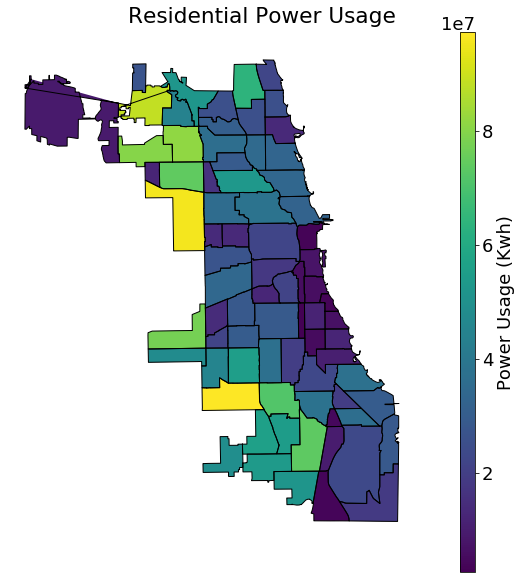

In [8]:
# Residential Power
data = resTotKwh['TOT_KWH']
title = "Residential Power Usage"
cbLabel = "Power Usage (Kwh)"
basemapPlotColormap(data,mapBounds,borderBounds,title,cbLabel,cmap)

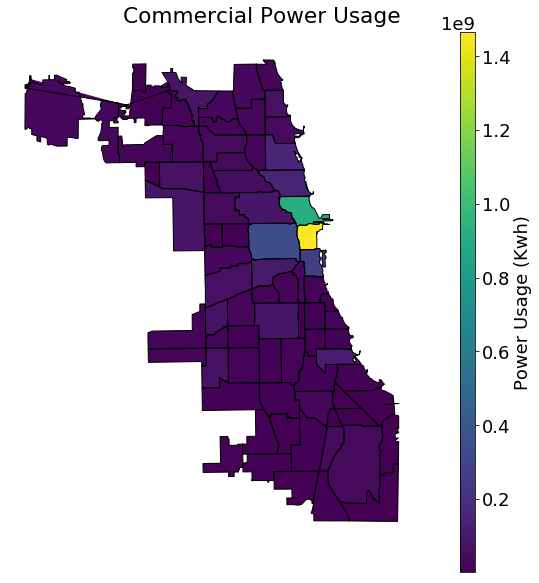

In [9]:
# commercial Power
data = comTotKwh['TOT_KWH']
title = "Commercial Power Usage"
cbLabel = "Power Usage (Kwh)"
basemapPlotColormap(data,mapBounds,borderBounds,title,cbLabel,cmap)

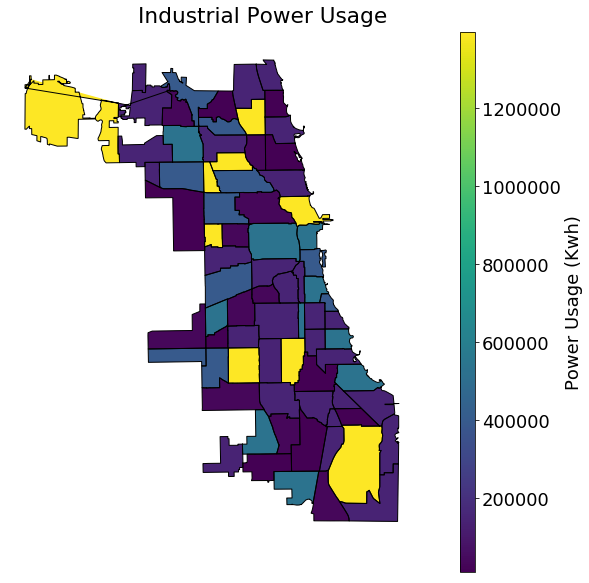

In [10]:
# Industrial Power
data = indTotKwh['TOT_KWH']
title = "Industrial Power Usage"
cbLabel = "Power Usage (Kwh)"
basemapPlotColormap(data,mapBounds,borderBounds,title,cbLabel,cmap)

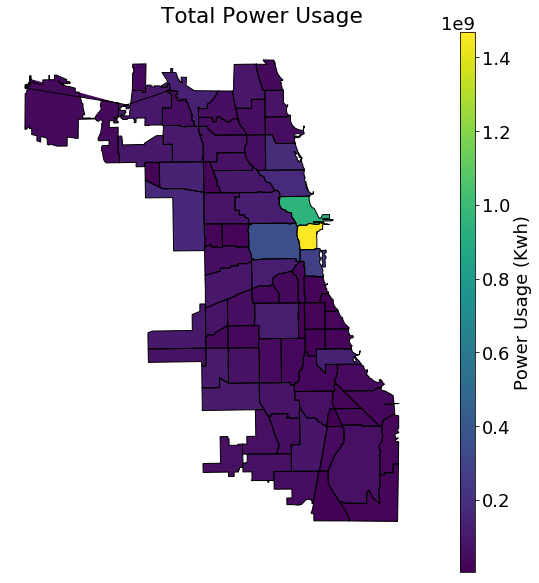

In [11]:
# Total Power
data = totKwh['TOT_KWH']
title = "Total Power Usage"
cbLabel = "Power Usage (Kwh)"
basemapPlotColormap(data,mapBounds,borderBounds,title,cbLabel,cmap)

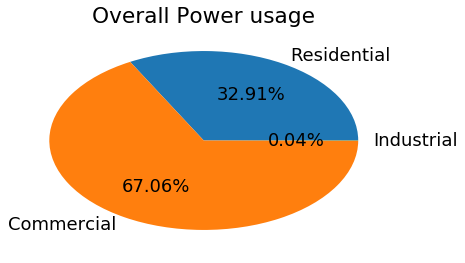

In [12]:
totalResKwh = sum(resTotKwh['TOT_KWH'])
totalComKwh = sum(comTotKwh['TOT_KWH'])
totalIndKwh = sum(indTotKwh['TOT_KWH'])
x = [totalResKwh,totalComKwh,totalIndKwh]
labels = ["Residential","Commercial","Industrial"]
fig, ax = plt.subplots() # create a plot
ax.pie(x, labels=labels, autopct='%1.2f%%')
ax.set_title('Overall Power usage')
fig.tight_layout()
plt.show()
#fig.savefig('PowerPie.png',bbox_inches='tight')

## <center> <font size = +3>Heat Usage Per Community Area</font></center>

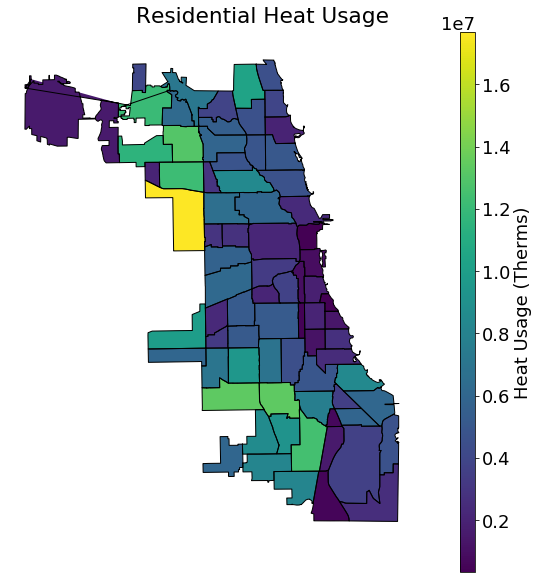

In [13]:
# Residentaial heat
data = resTotTherm['TOT_THERM']
title = "Residential Heat Usage"
cbLabel = "Heat Usage (Therms)"
basemapPlotColormap(data,mapBounds,borderBounds,title,cbLabel,cmap)

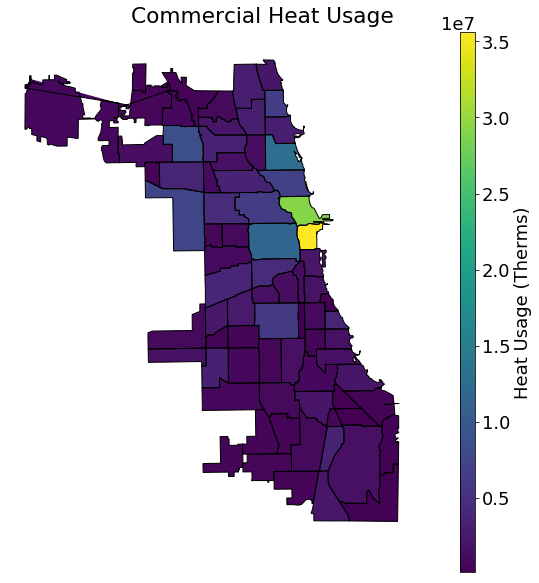

In [14]:
# commercial heat
data = comTotTherm['TOT_THERM']
title = "Commercial Heat Usage"
cbLabel = "Heat Usage (Therms)"
basemapPlotColormap(data,mapBounds,borderBounds,title,cbLabel,cmap)

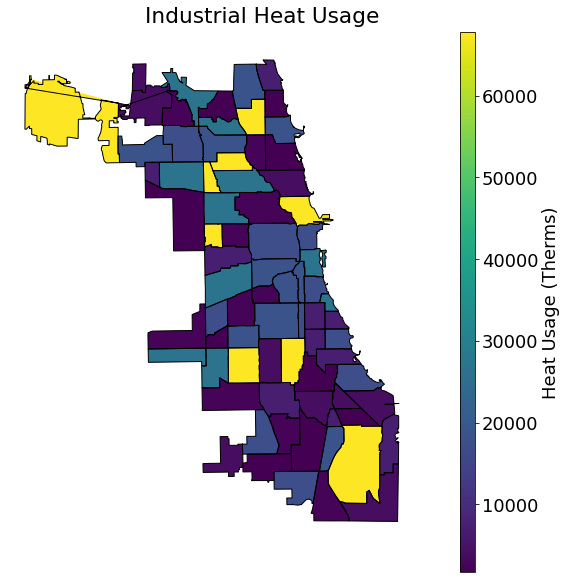

In [15]:
# Industrial Heat
data = indTotTherm['TOT_THERM']
title = "Industrial Heat Usage"
cbLabel = "Heat Usage (Therms)"
basemapPlotColormap(data,mapBounds,borderBounds,title,cbLabel,cmap)

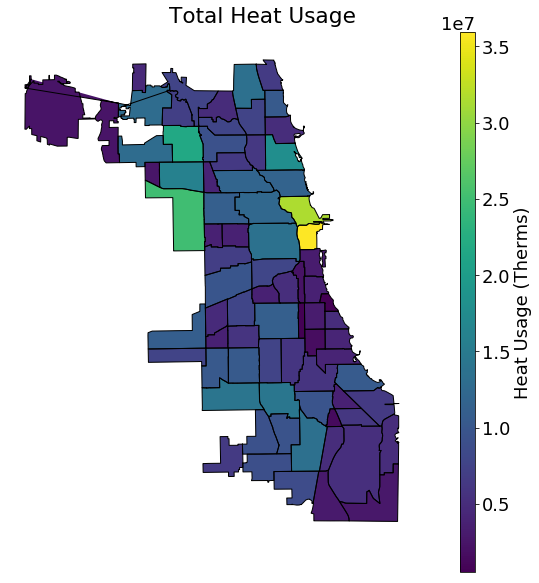

In [16]:
# Total heat
data = totTherm['TOT_THERM']
title = "Total Heat Usage"
cbLabel = "Heat Usage (Therms)"
basemapPlotColormap(data,mapBounds,borderBounds,title,cbLabel,cmap)

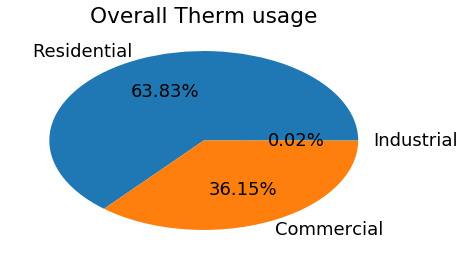

In [17]:
totalResTherm = sum(resTotTherm['TOT_THERM'])
totalComTherm = sum(comTotTherm['TOT_THERM'])
totalIndTherm = sum(indTotTherm['TOT_THERM'])
x = [totalResTherm,totalComTherm,totalIndTherm]
labels = ["Residential","Commercial","Industrial"]

fig, ax = plt.subplots() # create a plot
ax.pie(x, labels=labels, autopct='%1.2f%%')
ax.set_title('Overall Therm usage')
fig.tight_layout()
plt.show()
#fig.savefig('ThermPie.png',bbox_inches='tight')

In [18]:
#-----------------------------------------------------------------------------
# Configure connection to api

plotly.tools.set_credentials_file(username='mayamcda', api_key='wbZDJmio6roY1RtCjOVt')
#------------------------------------------------------------------------------------
# Bringing in data
connection = pymysql.connect(host='localhost',
                             user='root',
                             password=password,
                             db='ChicagoEnergy',
                             charset='utf8mb4',
                             cursorclass=pymysql.cursors.DictCursor)

# Use ''' stuff ''' for multi-line string



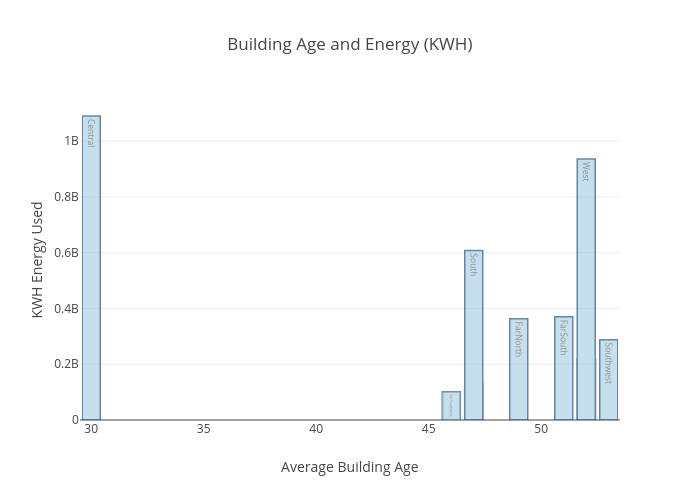

In [19]:
#------------------------------------------------------------------------------------
# Bar chart for average building age vs KWH
init_notebook_mode(connected=True)


districtNames=pd.read_sql_query(''' SELECT DISTRICT
FROM districts''', con=connection)
buildAge=pd.read_sql_query(''' SELECT AVERAGE_BUILDING_AGE
FROM districts''', con=connection)
totalKWH=pd.read_sql_query(''' SELECT TOTAL_KWH
FROM districts''', con=connection)
totalTHERM=pd.read_sql_query(''' SELECT TOTAL_THERMS
FROM districts''', con=connection)
totalPop=pd.read_sql_query(''' SELECT TOTAL_POPULATION
FROM districts''', con=connection)

df=pd.concat([districtNames,buildAge,totalPop,totalKWH,totalTHERM], axis=1)

data1=[
    go.Bar(
        x=df['AVERAGE_BUILDING_AGE'],
        y=df['TOTAL_KWH'],
        text=df['DISTRICT'],
        textposition = "auto",
        marker=dict(
            color='rgb(158,202,225)',
            line=dict(
                color='rgb(8,48,107)',
                width=1.5),
        ),
            opacity=0.6
        )]
layout1 = go.Layout(
    title=" Building Age and Energy (KWH)", xaxis=dict(title='Average Building Age'), yaxis=dict(title='KWH Energy Used'))
fig1 = go.Figure(data=data1, layout=layout1)
py.iplot(fig1, filename='KWH vs Building Age')
#py.image.save_as(fig1, filename='KWHBuildAgeBar.png')
py.image.ishow(fig1)

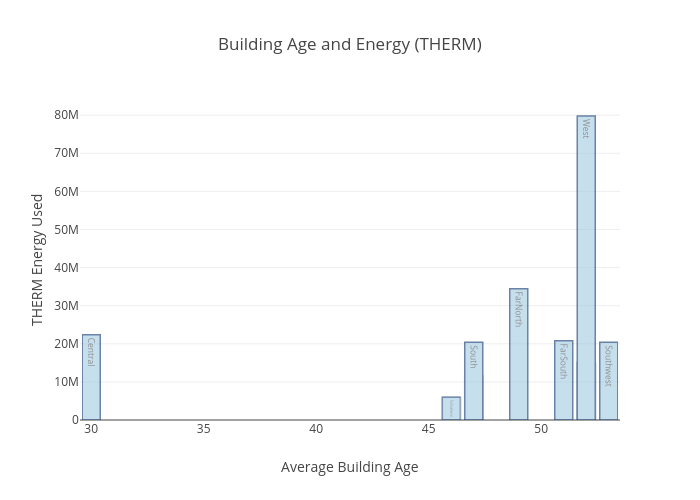

In [20]:
#------------------------------------------------------------------------------------
# Bar chart for average building age vs Therm


data2=[
    go.Bar(
        x=df['AVERAGE_BUILDING_AGE'],
        y=df['TOTAL_THERMS'],
        text=df['DISTRICT'],
        textposition = "auto",
        marker=dict(
            color='rgb(158,202,225)',
            line=dict(
                color='rgb(8,48,107)',
                width=1.5),
        ),
            opacity=0.6
        )]
layout2 = go.Layout(
    title=" Building Age and Energy (THERM)", xaxis=dict(title='Average Building Age'), yaxis=dict(title='THERM Energy Used'))
fig2 = go.Figure(data=data2, layout=layout2)
py.iplot(fig2, filename='THERM vs Building Age')
#py.image.save_as(fig2, filename='ThermBuildAgeBar.png')
py.image.ishow(fig2)

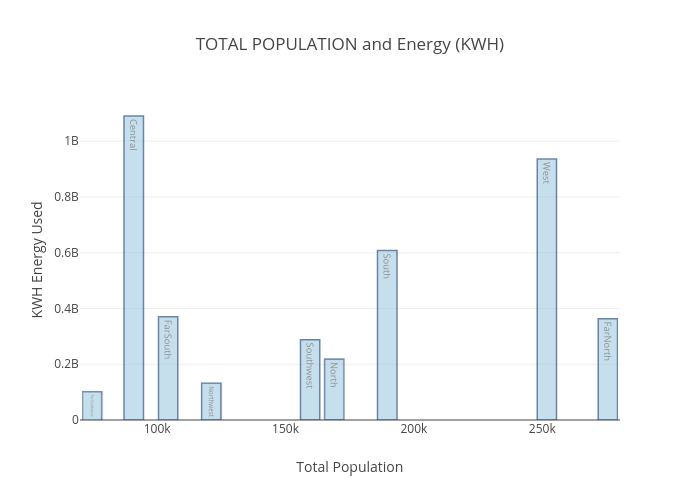

In [21]:
#------------------------------------------------------------------------------------
# Bar chart for total population vs KWH


data3=[
    go.Bar(
        x=df['TOTAL_POPULATION'],
        y=df['TOTAL_KWH'],
        text=df['DISTRICT'],
        textposition = "auto",
        marker=dict(
            color='rgb(158,202,225)',
            line=dict(
                color='rgb(8,48,107)',
                width=1.5),
        ),
            opacity=0.6
        )]
layout3 = go.Layout(
    title=" TOTAL POPULATION and Energy (KWH)", xaxis=dict(title='Total Population'), yaxis=dict(title='KWH Energy Used'))
fig3 = go.Figure(data=data3, layout=layout3)
py.iplot(fig3, filename='KWH vs Total Population')
#py.image.save_as(fig3, filename='KWHPopBar.png')
py.image.ishow(fig3)

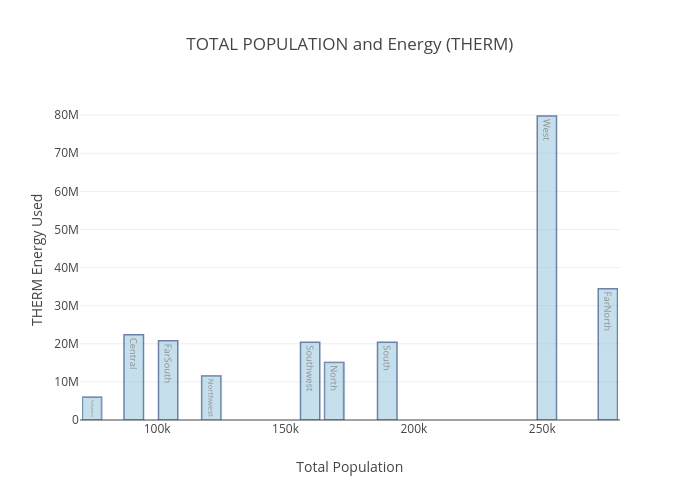

In [22]:
#------------------------------------------------------------------------------------
# Bar chart for total population vs THERM


data4=[
    go.Bar(
        x=df['TOTAL_POPULATION'],
        y=df['TOTAL_THERMS'],
        text=df['DISTRICT'],
        textposition = "auto",
        marker=dict(
            color='rgb(158,202,225)',
            line=dict(
                color='rgb(8,48,107)',
                width=1.5),
        ),
            opacity=0.6
        )]
layout4 = go.Layout(
    title= "TOTAL POPULATION and Energy (THERM)", xaxis=dict(title='Total Population'),
    yaxis=dict(title='THERM Energy Used'))
fig4 = go.Figure(data=data4, layout=layout4)
py.iplot(fig4, filename='THERM vs Total Population')
#py.image.save_as(fig4, filename='ThermPopBar.png')
py.image.ishow(fig4)

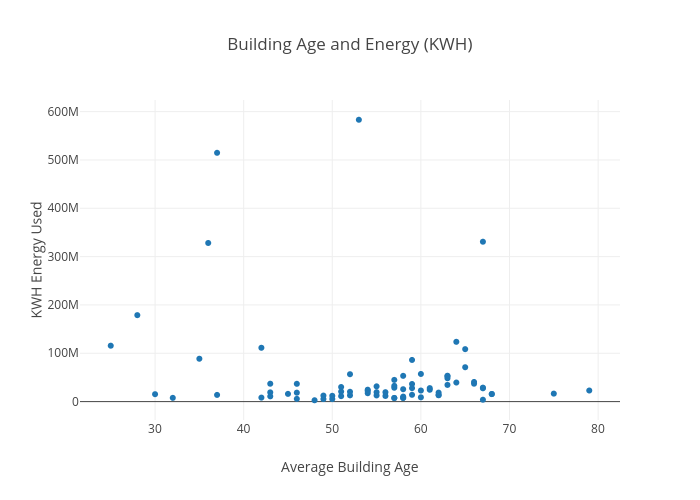

In [23]:
#----------------------------------------------------------------------------------------
#scatter plot of community area average building age vs KWH
comBuildAge=pd.read_sql_query(''' SELECT AVERAGE_BUILDING_AGE
FROM communityareas''', con=connection)
comTotalKWH=pd.read_sql_query(''' SELECT TOTAL_KWH
FROM communityareas''', con=connection)
comTotalTHERM=pd.read_sql_query(''' SELECT TOTAL_THERMS
FROM communityareas''', con=connection)
comTotalPop=pd.read_sql_query(''' SELECT TOTAL_POPULATION
FROM communityareas''', con=connection)

comDf=pd.concat([comBuildAge,comTotalPop,comTotalKWH,comTotalTHERM], axis=1)
#comDf


data5=[
    go.Scatter(
        x=comDf['AVERAGE_BUILDING_AGE'],
        y=comDf['TOTAL_KWH'],
        mode='markers')]
layout5 =go.Layout(
    title= "Building Age and Energy (KWH)", xaxis=dict(title='Average Building Age'),
    yaxis=dict(title='KWH Energy Used'))
fig5 = go.Figure(data=data5, layout=layout5)
py.iplot(fig5, filename='Community KWH vs Building Age')
#py.image.save_as(fig5, filename='KWHBuildAgeScatter.png')
py.image.ishow(fig5)

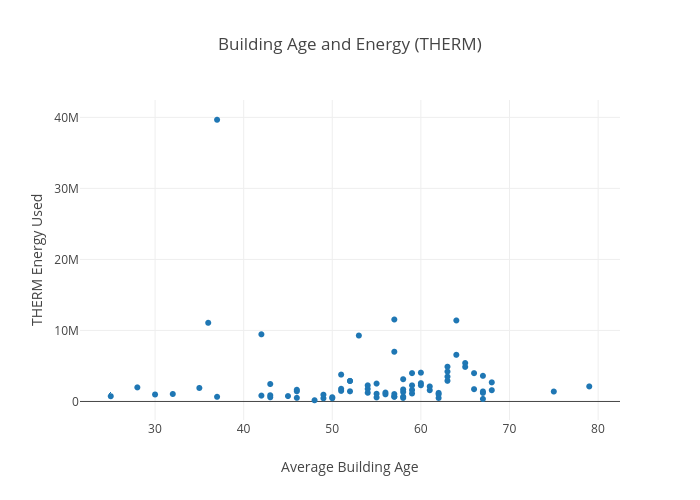

In [24]:
#----------------------------------------------------------------------------------------
#scatter plot of community area average building age vs THERM


data6=[
    go.Scatter(
        x=comDf['AVERAGE_BUILDING_AGE'],
        y=comDf['TOTAL_THERMS'],
        mode='markers')]
layout6 =go.Layout(
    title= "Building Age and Energy (THERM)", xaxis=dict(title='Average Building Age'),
    yaxis=dict(title='THERM Energy Used'))
fig6 = go.Figure(data=data6, layout=layout6)
py.iplot(fig6, filename='Community THERM vs Building Age')
#py.image.save_as(fig6, filename='ThermBuildAgeScatter.png')
py.image.ishow(fig6)

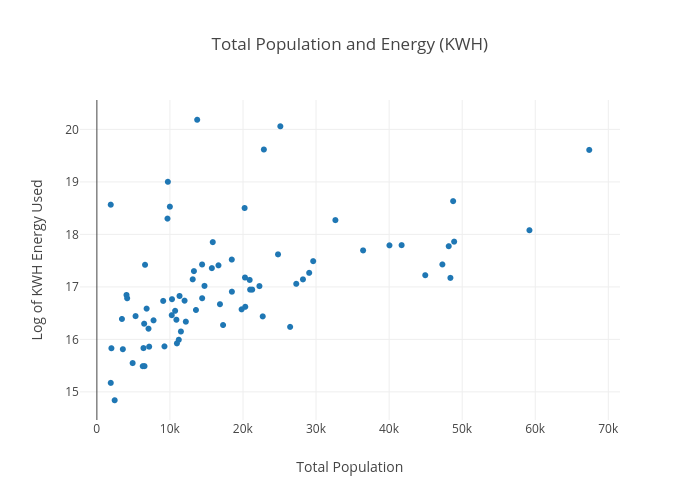

In [25]:
#----------------------------------------------------------------------------------------
#scatter plot of community area total pop vs therms


data7=[
    go.Scatter(
        x=comDf['TOTAL_POPULATION'],
        y=np.log(comDf['TOTAL_KWH']),
        mode='markers')]
layout7 =go.Layout(
    title= "Total Population and Energy (KWH)", xaxis=dict(title='Total Population'),
    yaxis=dict(title='Log of KWH Energy Used'))
fig7 = go.Figure(data=data7, layout=layout7)
py.iplot(fig7, filename='Community KWH vs Total Population')
#py.image.save_as(fig7, filename='KWHPopScatter.png')
py.image.ishow(fig7)

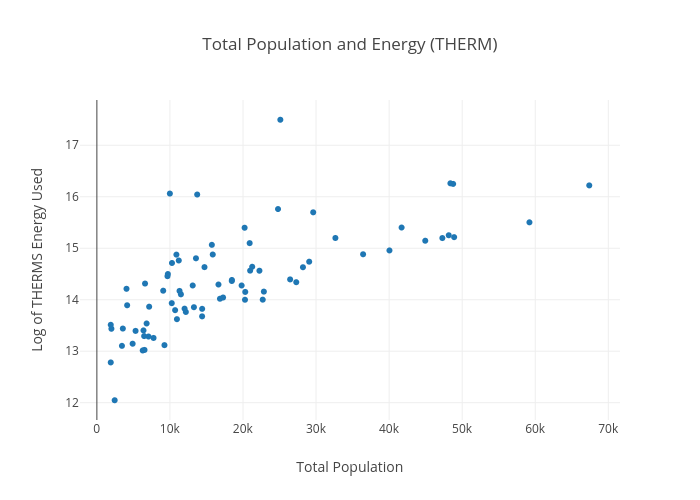

In [26]:
#----------------------------------------------------------------------------------------
#scatter plot of community area total pop vs therms


data8=[
    go.Scatter(
        x=comDf['TOTAL_POPULATION'],
        y=np.log(comDf['TOTAL_THERMS']),
        mode='markers')]
layout8 =go.Layout(
    title= "Total Population and Energy (THERM)", xaxis=dict(title='Total Population'),
    yaxis=dict(title='Log of THERMS Energy Used'))
fig8 = go.Figure(data=data8, layout=layout8)
py.iplot(fig8, filename='Community THERMS vs Total Population')
#py.image.save_as(fig8, filename='ThermPopScatter.png')
py.image.ishow(fig8)
connection.close()

C:\Users\sleep\Anaconda3\lib\site-packages\pandas\plotting\_core.py:1714: UserWarning:

Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access



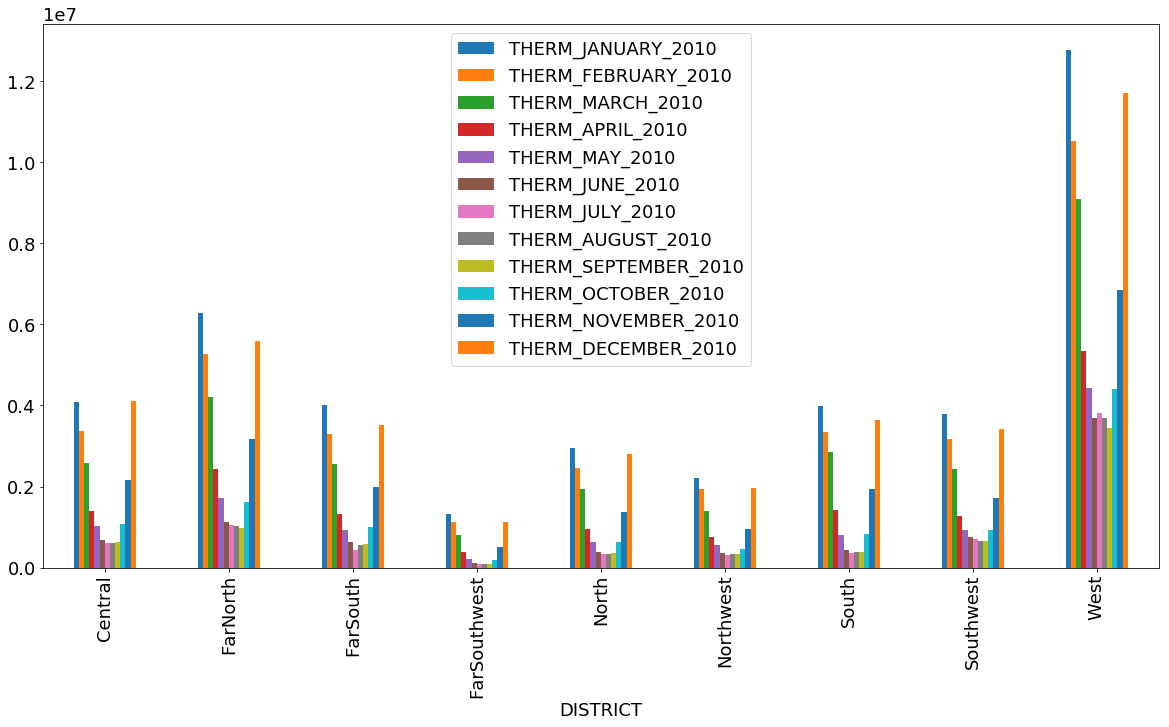

In [27]:
import pandas as pd
import numpy as np
import pymysql

connection = pymysql.connect(host='localhost', user='root', passwd=password,db='ChicagoEnergy')
cursor = connection.cursor()
df=pd.read_sql('Select DISTRICT, THERM_JANUARY_2010, THERM_FEBRUARY_2010, THERM_MARCH_2010,THERM_APRIL_2010,THERM_MAY_2010,THERM_JUNE_2010,THERM_JULY_2010,THERM_AUGUST_2010,THERM_SEPTEMBER_2010,THERM_OCTOBER_2010,THERM_NOVEMBER_2010,THERM_DECEMBER_2010 from Districts',connection )
#columns = 
# df.reindex(columns=columns)
#data2 = df.set_index('DISTRICT')
#print(data2)
# columns.index(['DISTRICT'])
df.plot(x='DISTRICT', y=['THERM_JANUARY_2010', 'THERM_FEBRUARY_2010', 'THERM_MARCH_2010','THERM_APRIL_2010','THERM_MAY_2010','THERM_JUNE_2010','THERM_JULY_2010','THERM_AUGUST_2010','THERM_SEPTEMBER_2010','THERM_OCTOBER_2010','THERM_NOVEMBER_2010','THERM_DECEMBER_2010'], kind="bar",figsize=(20,10))
plt.savefig('MonthlyThermBar.png',bbox_inches='tight', pad_inches=0.3)
plt.show()

C:\Users\sleep\Anaconda3\lib\site-packages\pandas\plotting\_core.py:1714: UserWarning:

Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access



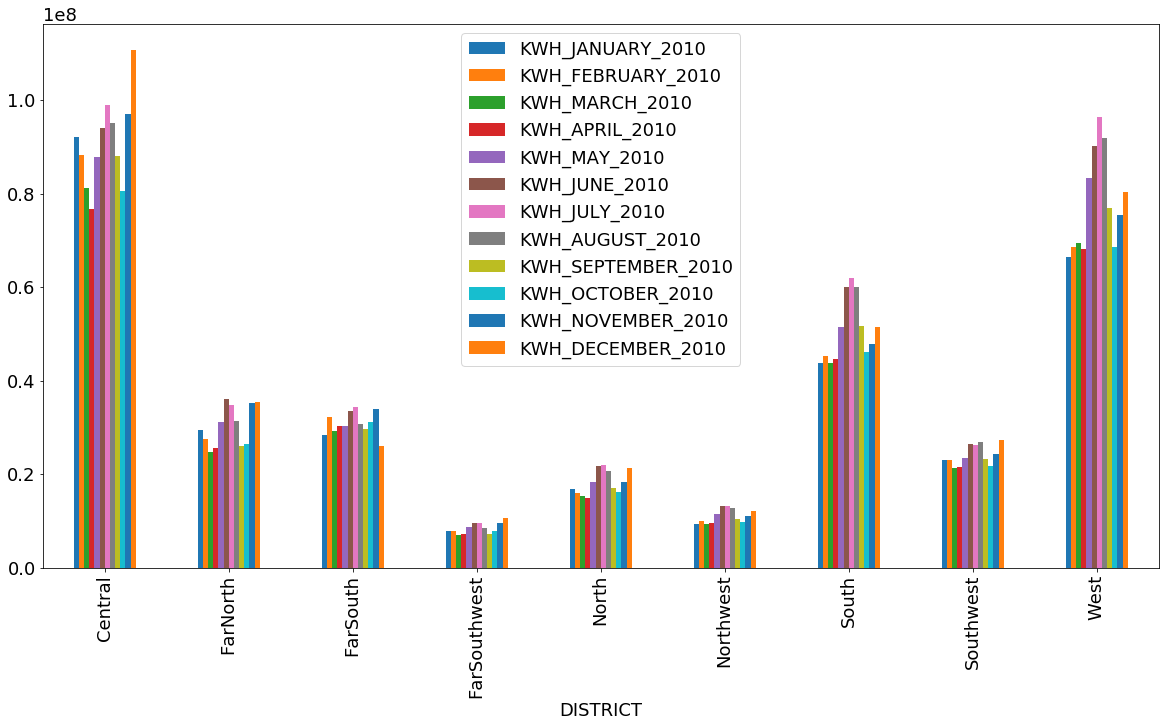

In [28]:
connection = pymysql.connect(host='localhost', user='root', passwd=password,db='ChicagoEnergy')
cursor = connection.cursor()
df=pd.read_sql('Select DISTRICT, KWH_JANUARY_2010, KWH_FEBRUARY_2010, KWH_MARCH_2010, KWH_APRIL_2010, KWH_MAY_2010, KWH_JUNE_2010, KWH_JULY_2010, KWH_AUGUST_2010, KWH_SEPTEMBER_2010, KWH_OCTOBER_2010, KWH_NOVEMBER_2010, KWH_DECEMBER_2010 from Districts',connection )
#columns = 
# df.reindex(columns=columns)
#data2 = df.set_index('DISTRICT')
#print(data2)
# columns.index(['DISTRICT'])
df.plot(x='DISTRICT', y=['KWH_JANUARY_2010', 'KWH_FEBRUARY_2010', 'KWH_MARCH_2010', 'KWH_APRIL_2010', 'KWH_MAY_2010', 'KWH_JUNE_2010', 'KWH_JULY_2010', 'KWH_AUGUST_2010', 'KWH_SEPTEMBER_2010', 'KWH_OCTOBER_2010', 'KWH_NOVEMBER_2010', 'KWH_DECEMBER_2010'], kind="bar",figsize=(20,10))
plt.savefig('MonthlyKWHBar.png',bbox_inches='tight', pad_inches=0.8)
plt.show()

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import pymysql.cursors
import matplotlib.colors as colors
import matplotlib.cm as cmx
import math
import numpy as np
mpl.rcParams["font.size"] = '18'

def getConnection():
     
    # You can change the connection arguments.
    connection = pymysql.connect(host='localhost',
                                 user='root',
                                 password=password,                             
                                 db='ChicagoEnergy',
                                 charset='utf8mb4',
                                 cursorclass=pymysql.cursors.DictCursor)
    return connection

con = getConnection()

sqft_therm_res = pd.read_sql("SELECT THERMS_TOTAL_SQFT,TOTAL_THERMS,BUILDING_TYPE FROM CensusBlocks WHERE THERMS_TOTAL_SQFT != 0 AND BUILDING_TYPE='Residential'",con)
sqft_therm_ind = pd.read_sql("SELECT THERMS_TOTAL_SQFT,TOTAL_THERMS,BUILDING_TYPE FROM CensusBlocks WHERE THERMS_TOTAL_SQFT != 0 AND BUILDING_TYPE='Industrial'",con)
sqft_therm_com = pd.read_sql("SELECT THERMS_TOTAL_SQFT,TOTAL_THERMS,BUILDING_TYPE FROM CensusBlocks WHERE THERMS_TOTAL_SQFT != 0 AND BUILDING_TYPE='Commercial'",con)
sqft_kwh_res = pd.read_sql("SELECT KWH_TOTAL_SQFT, TOTAL_KWH,BUILDING_TYPE FROM CensusBlocks WHERE BUILDING_TYPE='Residential'",con)
sqft_kwh_ind = pd.read_sql("SELECT KWH_TOTAL_SQFT, TOTAL_KWH,BUILDING_TYPE FROM CensusBlocks WHERE BUILDING_TYPE='Industrial'",con)
sqft_kwh_com = pd.read_sql("SELECT KWH_TOTAL_SQFT, TOTAL_KWH,BUILDING_TYPE FROM CensusBlocks WHERE BUILDING_TYPE='Commercial'",con)



C:\Users\sleep\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning:

divide by zero encountered in log



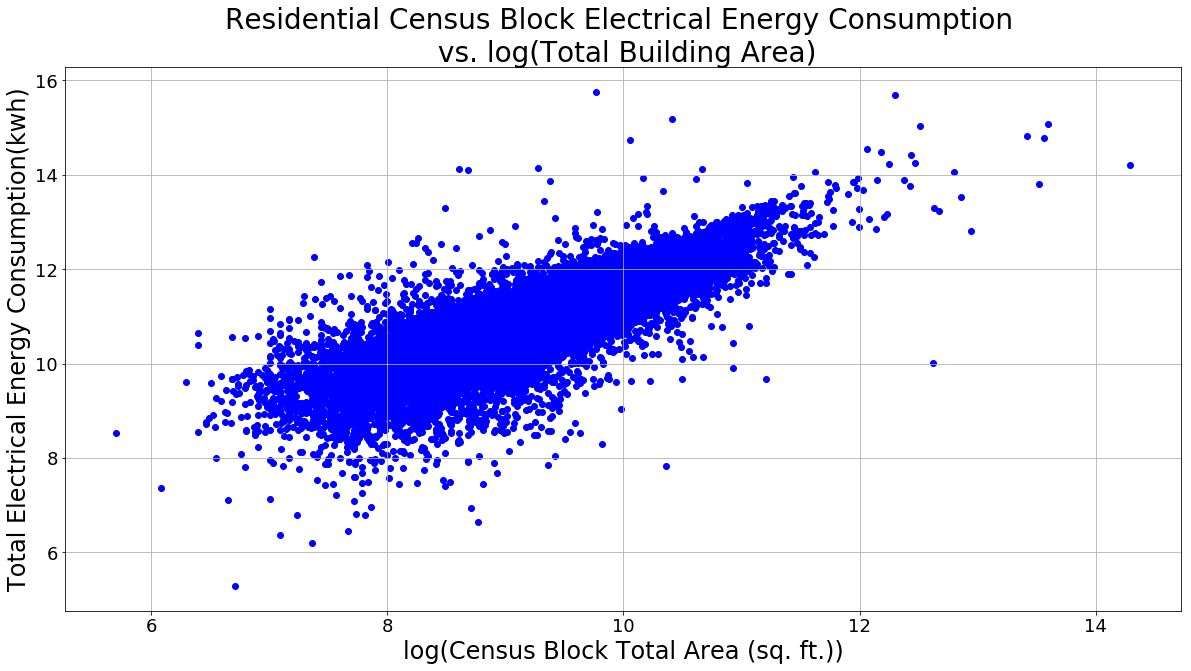

In [30]:
fig, ax1 = plt.subplots(figsize=(20,10))
ax1.grid()
ax1.scatter(x = np.log(sqft_kwh_res["KWH_TOTAL_SQFT"]),y=np.log(sqft_kwh_res["TOTAL_KWH"]),c='b')
ax1.set_xlabel('log(Census Block Total Area (sq. ft.))',fontsize=24)
ax1.set_ylabel('Total Electrical Energy Consumption(kwh)',fontsize=24)
ax1.set_title('Residential Census Block Electrical Energy Consumption \n vs. log(Total Building Area)',{'fontsize':'28'})
plt.show()
#fig.savefig('ResElecScatter.png')

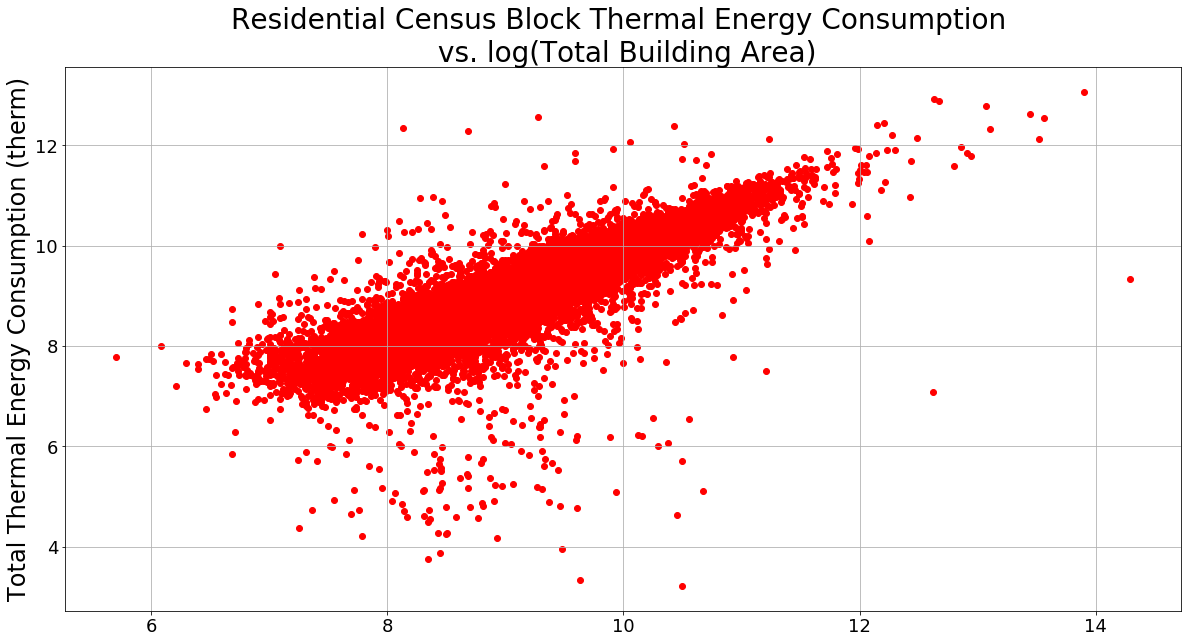

In [31]:
fig, ax2 = plt.subplots(figsize=(20,10))
ax2.grid()
ax2.scatter(x = np.log(sqft_therm_res["THERMS_TOTAL_SQFT"]),y=np.log(sqft_therm_res["TOTAL_THERMS"]),c='r')
ax2.set_ylabel('Total Thermal Energy Consumption (therm)',fontsize = 24)
ax1.set_xlabel('log(Census Block Total Area (sq. ft.))',fontsize=24)
ax2.set_title('Residential Census Block Thermal Energy Consumption \n vs. log(Total Building Area)',{'fontsize':'28'})
plt.show()
#fig.savefig('ResThermScatter.png')

C:\Users\sleep\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning:

divide by zero encountered in log



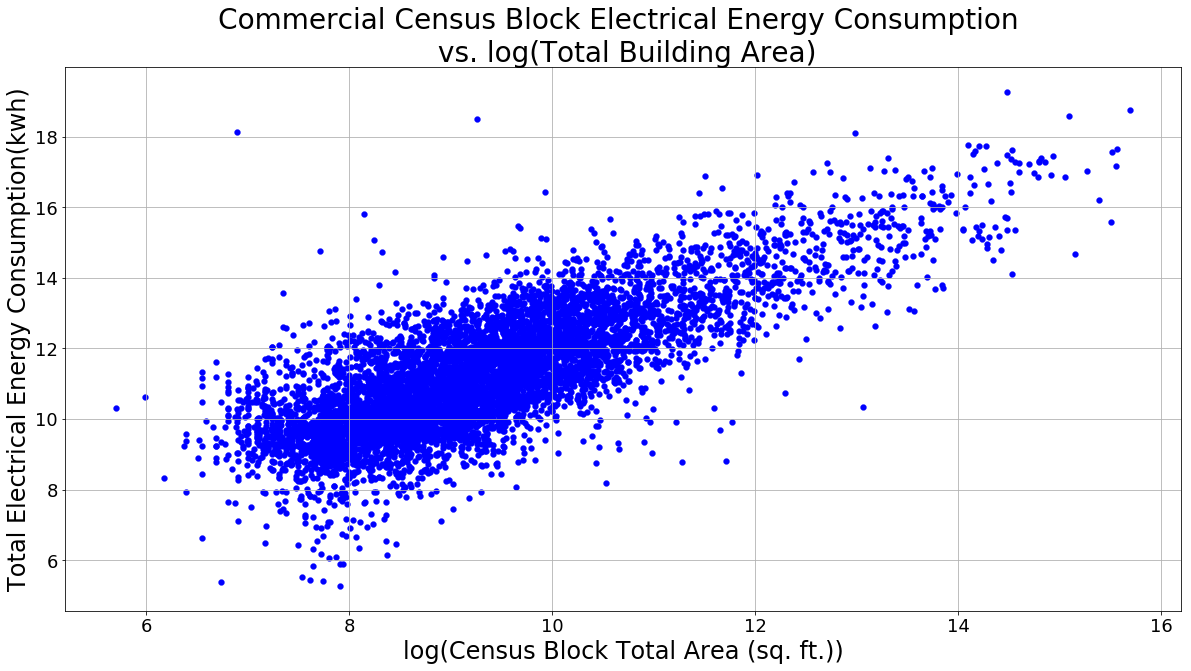

In [32]:
fig, ax1 = plt.subplots(figsize=(20,10))
ax1.grid()
ax1.scatter(x = np.log(sqft_kwh_com["KWH_TOTAL_SQFT"]),y=np.log(sqft_kwh_com["TOTAL_KWH"]),c='b',linewidths=0.25)
ax1.set_xlabel('log(Census Block Total Area (sq. ft.))',fontsize=24)
ax1.set_ylabel('Total Electrical Energy Consumption(kwh)',fontsize = 24)
ax1.set_title('Commercial Census Block Electrical Energy Consumption \n vs. log(Total Building Area)',{'fontsize':'28'})
plt.show()
#fig.savefig('ComElecScatter.png')

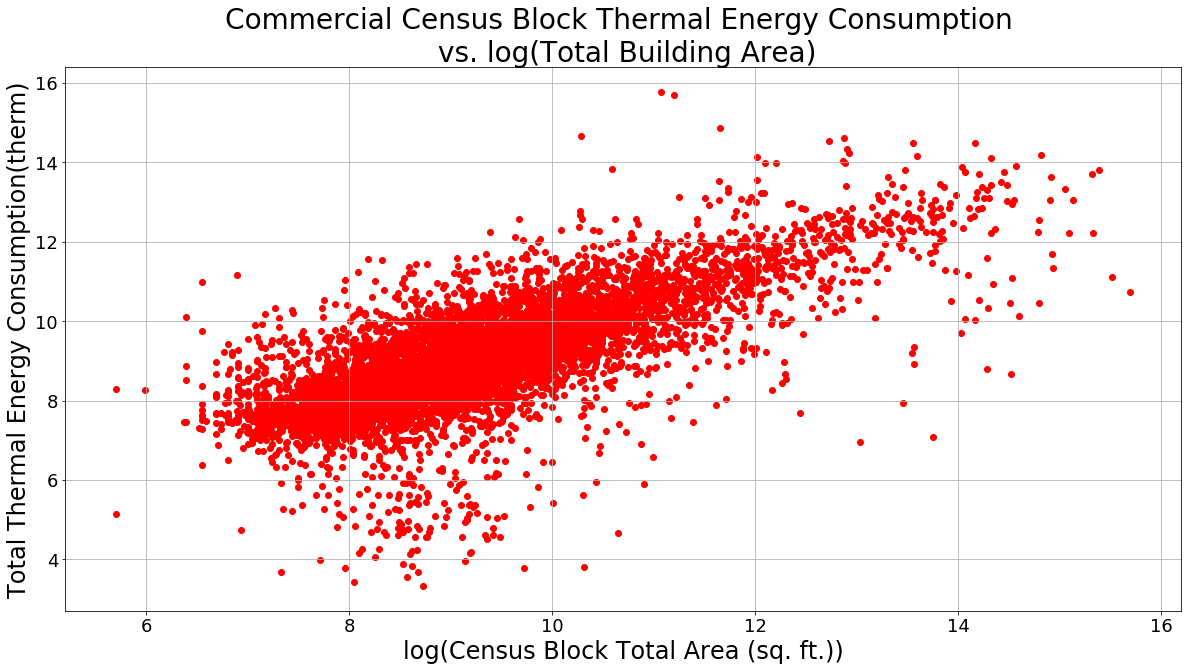

In [33]:
fig, ax1 = plt.subplots(figsize=(20,10))
ax1.grid()
ax1.scatter(x = np.log(sqft_therm_com["THERMS_TOTAL_SQFT"]),y=np.log(sqft_therm_com["TOTAL_THERMS"]),c='r')
ax1.set_ylabel('Total Thermal Energy Consumption(therm)',fontsize = 24)
ax1.set_xlabel('log(Census Block Total Area (sq. ft.))',fontsize=24)
ax1.set_title('Commercial Census Block Thermal Energy Consumption \n vs. log(Total Building Area)',{'fontsize':'28'})
plt.show()
#fig.savefig('ComThermScatter.png')

## <center><font size = +3> Total Building Area Against Energy Usage </font></center>

# <center><font size=+6> 2010 Chicago Energy Data </font></center>

## <center><font size = +3>District and Community Area Level Analysis</font></center>